In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/

/content/drive/MyDrive


In [3]:
cd 713/

/content/drive/MyDrive/713


In [4]:
cd PMF_Raw Date_QueenSt_PM10/

/content/drive/MyDrive/713/PMF_Raw Date_QueenSt_PM10


# Data extraction

Replace negative with mean value

In [23]:
import pandas as pd

def read_data(file_path, sheet_name):
    """
    Read Excel data.

    parameter:
    file_path: Excel file path.
    sheet_name: worksheet name.

    return:
    df: read DataFrame.
    """
    return pd.read_excel(file_path, sheet_name=sheet_name)

def split_and_adjust_data(df):
    """
    Separate dataframe into two tables, and adjust column names.

    parameter:
    df: original DataFrame.

    return:
    df1, df2: separated and adjusted DataFrame.
    """
    # Find rows with all missing values
    full_missing_rows = df[df.isna().all(axis=1)]

    if full_missing_rows.empty:
        # If no rows with missing values, return the original data and an empty DataFrame
        return df, pd.DataFrame()

    # Get the last index of rows with missing values
    last_missing_index = full_missing_rows.index[-1]

    # Separate into two DataFrames: df1 before the missing rows, df2 after the missing rows
    df1 = df.iloc[:last_missing_index]
    df2 = df.iloc[last_missing_index + 1:]

    # Set headers for df1 and df2 using the third row
    df1.columns = df1.iloc[2]
    df1 = df1[3:].reset_index(drop=True)  # Data starts from the fourth row, reset the index

    df2.columns = df2.iloc[2]  # Set the header as the third row in df2
    df2 = df2[3:].reset_index(drop=True)  # Data starts from the fourth row, reset the index

    # Set the first two columns of df1 and df2 to 'Base Run' and 'Date'
    df1.columns = ['Base Run', 'Date'] + df1.columns[2:].tolist()
    df2.columns = ['Base Run', 'Date'] + df2.columns[2:].tolist()

    # Clean up blank values in df2 column names
    new_columns = [col if pd.notna(col) else None for col in df2.columns]
    new_columns = [col for col in new_columns if col is not None]

    if new_columns[2] is None:
        new_columns[2] = new_columns[3]
        new_columns[3] = 'Unknown'  # Replace with 'Unknown'
    else:
        new_columns.append('Unknown')  # Add 'Unknown' at the end if the third column isn't blank

    # Ensure the number of columns match
    if len(new_columns) < len(df2.columns):
        new_columns.append('Unknown')

    df2.columns = new_columns

    # Ensure both df1 and df2 have the same columns
    df2.columns = df1.columns  # Set df2's columns to be the same as df1's columns

    return df1, df2

def replace_negative_with_mean(df):
    """
    Replace negative values in the DataFrame with the column mean.

    parameter:
    df: DataFrame where negative values will be replaced.

    return:
    df: DataFrame with negative values replaced by column means.
    """
    # Iterate through each column
    for column in df.columns:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df[column]):
            # Calculate the mean of the column excluding negative values
            column_mean = df[column][df[column] >= 0].mean()

            # If there are no positive values in the column, set mean to 0 to prevent errors
            if pd.isna(column_mean):
                column_mean = 0

            # Replace negative values with the column mean
            df[column] = df[column].apply(lambda x: column_mean if x < 0 else x)

    return df

def drop_nan_columns(df):
    """
    Drop columns that contain NaN values.

    parameter:
    df: DataFrame from which columns with NaN values will be dropped.

    return:
    df: DataFrame without columns containing NaN values.
    """
    return df.dropna(axis=1, how='any')

# File path and worksheet name
file_path = 'RUN3PM10QUS_base.xlsx'
sheet_name = 'Contributions'

# Reading Excel Files
df = read_data(file_path, sheet_name)

# Separate data into two tables and adjust column names
df1, df2 = split_and_adjust_data(df)

# Drop the 'Base Run' column from both df1 and df2
df1 = df1.drop(columns=['Base Run'])
df2 = df2.drop(columns=['Base Run'])

# Replace negative values with column mean in df2
df2 = replace_negative_with_mean(df2)

# Drop columns with NaN values from df2
df2 = drop_nan_columns(df2)

# Iterate over each column (excluding 'Date') and replace negative values with the column mean
for column in df2.columns:
    if column != 'Date':  # Skip the 'Date' column
        column_mean = df2[column][df2[column] >= 0].mean()  # Calculate mean of non-negative values
        df2[column] = df2[column].apply(lambda x: column_mean if x < 0 else x)  # Replace negative values with the mean

# Print the updated df2
print(df2)


# Exclude the 'Date' column and check for the maximum negative value in the remaining columns
negative_values = df2[df2.drop(columns='Date') < 0]

# Find the maximum negative value across all columns
max_negative_value = negative_values.min().min()

# Print the row(s) containing the maximum negative value
max_negative_row = negative_values[negative_values == max_negative_value]
print(f"\nRow(s) with the maximum negative value ({max_negative_value}):")
print(max_negative_row)


           Date  Soil/Road dust   Sea salt  Diesel vehicles  Biomass burning  \
0    2006-01-06        0.513317   8.439309         6.310560         1.247557   
1    2006-01-07        0.530513   6.099226         4.156125         0.428755   
2    2006-01-08        0.796049   9.891116         4.541697         0.640065   
3    2006-01-09        0.981262  13.078541         3.186766         0.480054   
4    2006-01-11        0.685178  11.742033         2.949837         0.411649   
...         ...             ...        ...              ...              ...   
3671 2022-12-03        0.372388   7.925582         0.977875         0.839242   
3672 2022-12-09        1.012677   3.777699         0.802825         0.206434   
3673 2022-12-15        0.199243   1.070230         0.505696         0.249809   
3674 2022-12-21        0.537591   2.375560         0.870681         0.620426   
3675 2022-12-27        0.398015   4.420983         4.037588         0.616197   

      Construction  Petrol vehicles  Su

# Create Database

In [24]:
import sqlite3
import os

def drop_database(db_filename):
    # If the database file exists, delete it
    if os.path.exists(db_filename):
        os.remove(db_filename)
        print(f"Database file {db_filename} has been deleted.")
    else:
        print(f"Database file {db_filename} does not exist.")

def create_database(db_filename):
    # Connect to a SQLite database, this will create a new empty database file
    conn = sqlite3.connect(db_filename)

    # SQL statement to create a table
    create_dates_table = """
    CREATE TABLE IF NOT EXISTS Dates (
        date_id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT NOT NULL
    );
    """
    create_factors_table = """
    CREATE TABLE IF NOT EXISTS Factors (
        factor_id INTEGER PRIMARY KEY AUTOINCREMENT,
        factor_name TEXT NOT NULL
    );
    """
    create_contributions_table = """
    CREATE TABLE IF NOT EXISTS Contributions (
        contribution_id INTEGER PRIMARY KEY AUTOINCREMENT,
        date_id INTEGER,
        factor_id INTEGER,
        contribution_value REAL,
        FOREIGN KEY (date_id) REFERENCES Dates(date_id),
        FOREIGN KEY (factor_id) REFERENCES Factors(factor_id)
    );
    """

    # Execute SQL statements to create tables
    cursor = conn.cursor()
    cursor.execute(create_dates_table)
    cursor.execute(create_factors_table)
    cursor.execute(create_contributions_table)

    # confirm operation
    conn.commit()

    # close connections
    conn.close()
    print(f"Database file {db_filename} has been created.")

# using function
db_filename = 'trend_analysis_contributions.db'
drop_database(db_filename)  # Delete database
create_database(db_filename)  # Create database

Database file trend_analysis_contributions.db has been deleted.
Database file trend_analysis_contributions.db has been created.


# Insert Data

In [31]:
import sqlite3
import os
import pandas as pd

# Function to drop the database if it exists
def drop_database(db_filename):
    if os.path.exists(db_filename):
        os.remove(db_filename)
        print(f"Database file {db_filename} has been deleted.")
    else:
        print(f"Database file {db_filename} does not exist.")

# Function to create the database and tables
def create_database(db_filename):
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Dates (
        date_id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT NOT NULL
    );
    """)
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Factors (
        factor_id INTEGER PRIMARY KEY AUTOINCREMENT,
        factor_name TEXT NOT NULL
    );
    """)
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Contributions (
        contribution_id INTEGER PRIMARY KEY AUTOINCREMENT,
        date_id INTEGER,
        factor_id INTEGER,
        contribution_value REAL,
        FOREIGN KEY (date_id) REFERENCES Dates(date_id),
        FOREIGN KEY (factor_id) REFERENCES Factors(factor_id)
    );
    """)
    conn.commit()
    conn.close()
    print(f"Database file {db_filename} has been created.")

# Function to insert dates into the Dates table
def insert_dates_to_table(db_filename, df):
    if 'Date' not in df.columns:
        print("Error: 'Date' column not found in DataFrame.")
        return
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    insert_date = "INSERT INTO Dates (date) VALUES (?)"
    df['Date'] = df['Date'].astype(str)
    df = df.dropna(subset=['Date'])
    for index, row in df.iterrows():
        cursor.execute(insert_date, (row['Date'],))
    conn.commit()
    conn.close()
    print("Dates have been inserted into the Dates table.")

# Function to insert factors into the Factors table
def insert_factors_to_table(db_filename, factors_list):
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    insert_factor = "INSERT INTO Factors (factor_name) VALUES (?)"
    for factor in factors_list:
        try:
            cursor.execute(insert_factor, (factor,))
        except sqlite3.IntegrityError:
            print(f"Factor {factor} already exists in the Factors table.")
    conn.commit()
    conn.close()
    print("Factors have been inserted into the Factors table.")

# Function to insert contributions into the Contributions table
def insert_contributions_to_table(db_filename, df):
    if 'Date' not in df.columns:
        print("Error: 'Date' column not found in DataFrame.")
        return
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    insert_contribution = "INSERT INTO Contributions (date_id, factor_id, contribution_value) VALUES (?, ?, ?)"
    for index, row in df.iterrows():
        date_id_query = "SELECT date_id FROM Dates WHERE date = ?"
        cursor.execute(date_id_query, (row['Date'],))
        date_id_result = cursor.fetchone()
        if date_id_result:
            date_id = date_id_result[0]
        else:
            print(f"Date {row['Date']} not found in Dates table.")
            continue
        for col in df.columns[df.columns != 'Date']:
            factor_id_query = "SELECT factor_id FROM Factors WHERE factor_name = ?"
            cursor.execute(factor_id_query, (col,))
            factor_id_result = cursor.fetchone()
            if factor_id_result:
                factor_id = factor_id_result[0]
            else:
                print(f"Factor {col} not found in Factors table.")
                continue
            contribution_value = row[col]
            cursor.execute(insert_contribution, (date_id, factor_id, contribution_value))
    conn.commit()
    conn.close()
    print("Contributions have been inserted into the Contributions table.")

# Database filename
db_filename = 'trend_analysis_contributions.db'

# Drop existing database
drop_database(db_filename)

# Create new database
create_database(db_filename)

# Assuming df2 is your DataFrame with contribution data
# Insert dates into the database
insert_dates_to_table(db_filename, df2)

# List of factors to insert
factors_list = ['Soil/Road dust', 'Sea salt', 'Diesel vehicles', 'Biomass burning', 'Construction', 'Petrol vehicles', 'Sulphate/Marine diesel']
# Insert factors into the database
insert_factors_to_table(db_filename, factors_list)

# Insert contributions into the database
insert_contributions_to_table(db_filename, df2)

Database file trend_analysis_contributions.db has been deleted.
Database file trend_analysis_contributions.db has been created.
Dates have been inserted into the Dates table.
Factors have been inserted into the Factors table.
Contributions have been inserted into the Contributions table.


In [36]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect(db_filename)

# Query the Dates table
df_dates = pd.read_sql_query("SELECT * FROM Dates", conn)
print(df_dates)

# Close the connection
conn.close()


      date_id        date
0           1  2006-01-06
1           2  2006-01-07
2           3  2006-01-08
3           4  2006-01-09
4           5  2006-01-11
...       ...         ...
3671     3672  2022-12-03
3672     3673  2022-12-09
3673     3674  2022-12-15
3674     3675  2022-12-21
3675     3676  2022-12-27

[3676 rows x 2 columns]


In [37]:
print("df2 columns:", df2.columns)


df2 columns: Index(['Date', 'Soil/Road dust', 'Sea salt', 'Diesel vehicles',
       'Biomass burning', 'Construction', 'Petrol vehicles',
       'Sulphate/Marine diesel'],
      dtype='object')


In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df2)

            Date  Soil/Road dust   Sea salt  Diesel vehicles  Biomass burning  \
0     2006-01-06        0.513317   8.439309         6.310560         1.247557   
1     2006-01-07        0.530513   6.099226         4.156125         0.428755   
2     2006-01-08        0.796049   9.891116         4.541697         0.640065   
3     2006-01-09        0.981262  13.078541         3.186766         0.480054   
4     2006-01-11        0.685178  11.742033         2.949837         0.411649   
5     2006-01-12        2.108797   7.348407         6.651207         1.393549   
6     2006-01-13        1.726057   5.476136         4.340512         1.732411   
7     2006-01-14        1.332827   8.459776         9.762734         0.277849   
8     2006-01-15        0.374231   5.988634         4.123701         0.238436   
9     2006-01-16        1.592921  19.411092         4.302619         1.163684   
10    2006-01-17        1.444198  17.657736         5.064777         1.007121   
11    2006-01-18        1.94

# Testing

In [33]:
import sqlite3
import pandas as pd

def verify_factors_in_database(db_filename, df2):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    print("Connected to the database.")

    # Query the Factors table to fetch all data
    try:
        cursor.execute("SELECT * FROM Factors")
        factors_from_db = cursor.fetchall()
        print("Data fetched from the Factors table.")
    except Exception as e:
        print(f"An error occurred while fetching data: {e}")
        return

    # Convert the fetched data to a DataFrame for easier comparison
    factors_df = pd.DataFrame(factors_from_db, columns=['factor_id', 'factor_name'])
    print("Converted fetched data to DataFrame.")

    # Get the factor names from df2 starting from the second column (after 'Date' column)
    expected_factors = df2.columns[1:].tolist()  # Assuming the first column is 'Date'
    print("Expected factors:", expected_factors)

    # Check if the factors from the Factors table match those in df2
    if set(factors_df['factor_name']) == set(expected_factors):
        print("Verification successful: All factors from df2 are present in the Factors table.")
    else:
        print("Verification failed: There are discrepancies between df2 and the Factors table.")

    # Close the connection
    conn.close()
    print("Database connection closed.")

# Use the verification function
verify_factors_in_database(db_filename, df2)


Connected to the database.
Data fetched from the Factors table.
Converted fetched data to DataFrame.
Expected factors: ['Soil/Road dust', 'Sea salt', 'Diesel vehicles', 'Biomass burning', 'Construction', 'Petrol vehicles', 'Sulphate/Marine diesel']
Verification successful: All factors from df2 are present in the Factors table.
Database connection closed.


In [34]:
import sqlite3
from datetime import datetime

def query_contribution(db_filename, date_str, factor_name):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Convert the date string to YYYY-MM-DD format
    try:
        # Attempt to parse the date string, assuming the format is 'M/D/YYYY'
        parsed_date = datetime.strptime(date_str, '%m/%d/%Y')
        # Format it as 'YYYY-MM-DD'
        date_str_formatted = parsed_date.strftime('%Y-%m-%d')
    except ValueError:
        print("Date string is not in the expected format 'M/D/YYYY'")
        return

    # Prepare the SQL query to fetch the date_id
    get_date_id = "SELECT date_id FROM Dates WHERE date = ?"

    # Prepare the SQL query to fetch the factor_id
    get_factor_id = "SELECT factor_id FROM Factors WHERE factor_name = ?"

    # Prepare the SQL query to fetch the contribution value
    get_contribution = """
    SELECT contribution_value FROM Contributions
    WHERE date_id = (SELECT date_id FROM Dates WHERE date = ?)
    AND factor_id = (SELECT factor_id FROM Factors WHERE factor_name = ?)
    """

    try:
        # Get date_id from the Dates table
        cursor.execute(get_date_id, (date_str_formatted,))
        date_id_result = cursor.fetchone()
        if date_id_result:
            date_id = date_id_result[0]
            print(f"Found date_id {date_id} for date {date_str_formatted}")
        else:
            print(f"No matching date_id found for date {date_str_formatted}")
            return

        # Get factor_id from the Factors table
        cursor.execute(get_factor_id, (factor_name,))
        factor_id_result = cursor.fetchone()
        if factor_id_result:
            factor_id = factor_id_result[0]
            print(f"Found factor_id {factor_id} for factor {factor_name}")
            # Query for the contribution value using the obtained date_id and factor_id
            cursor.execute(get_contribution, (date_str_formatted, factor_name,))
            contribution_result = cursor.fetchone()
            if contribution_result:
                print(f"Contribution value for {date_str_formatted} and {factor_name} is {contribution_result[0]}")
            else:
                print(f"No contribution value found for {date_str_formatted} and {factor_name}")
        else:
            print(f"No matching factor_id found for factor {factor_name}")
    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Close the database connection
        conn.close()

# Using the function to query data
db_filename = 'trend_analysis_contributions.db'
query_date = '1/30/2006'  # Example date
query_factor = 'Soil/Road dust'  # Example factor
query_contribution(db_filename, query_date, query_factor)


Found date_id 22 for date 2006-01-30
Found factor_id 1 for factor Soil/Road dust
Contribution value for 2006-01-30 and Soil/Road dust is 0.2444773606


Visulaizaton

RUN3PM10QUS_base- PM10

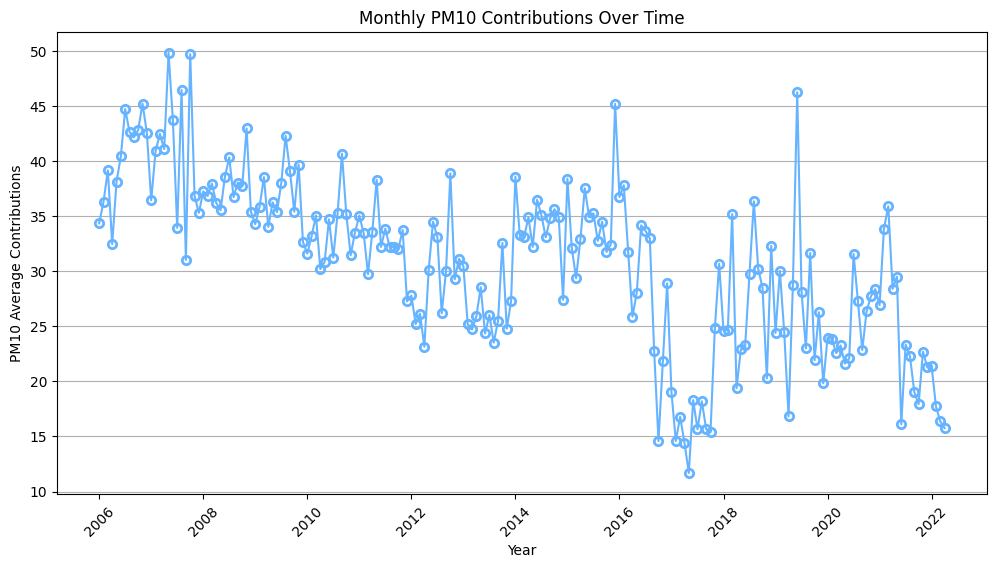

In [35]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

def fetch_contributions(db_filename):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_filename)
    query = """
    SELECT D.date,
           SUM(C.contribution_value) AS total_pm10
    FROM Contributions C
    JOIN Dates D ON C.date_id = D.date_id
    GROUP BY D.date
    ORDER BY D.date;
    """
    # Read data from the database into a DataFrame
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df
def plot_monthly_pm10_trend(df):
    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Extract the year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Group by year and month and calculate the average PM10 contribution for each month
    monthly_avg = df.groupby(['year', 'month'])['total_pm10'].mean().reset_index()

    # Create a 'month_year' column for better x-axis labels
    monthly_avg['month_year'] = monthly_avg['year'].astype(str) + '-' + monthly_avg['month'].astype(str).str.zfill(2)

    # Plot the monthly trend chart
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg['month_year'], monthly_avg['total_pm10'], marker='o', linestyle='-', color='#66b3ff', markerfacecolor='none', markeredgewidth=2)
    plt.title('Monthly PM10 Contributions Over Time')
    plt.xlabel('Year')
    plt.ylabel('PM10 Average Contributions')

    # Fix the x-axis to display labels every 2 years
    plt.xticks(ticks=range(0, len(monthly_avg['year']), 24), labels=monthly_avg['year'][::24], rotation=45)

    # Remove vertical grid lines and keep horizontal ones
    plt.grid(axis='y')

    plt.show()

# Define the database filename
db_filename = 'trend_analysis_contributions.db'

# Fetch the contribution data from the database
contributions_df = fetch_contributions(db_filename)

# Plot the monthly PM10 trend
plot_monthly_pm10_trend(contributions_df)

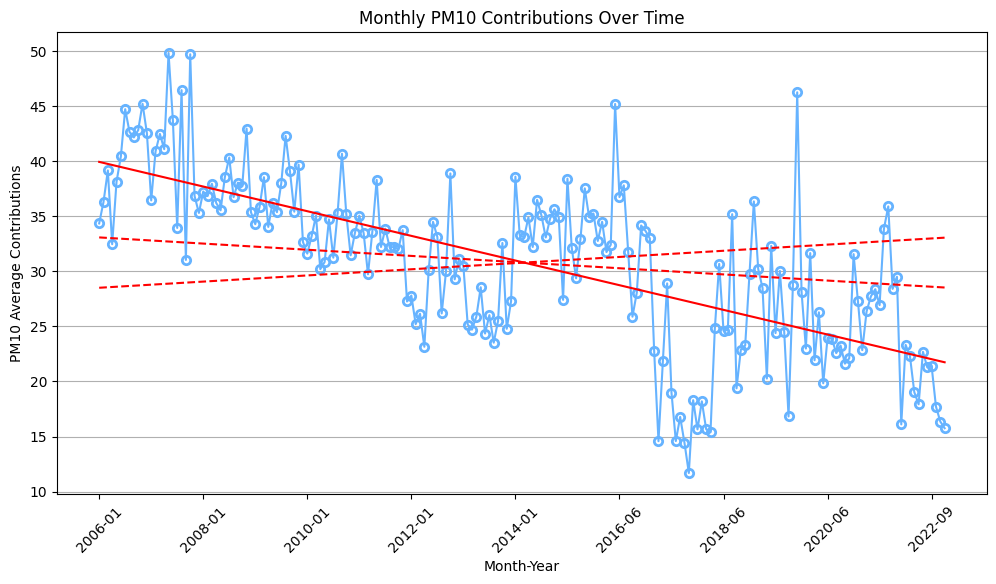

In [39]:
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

def fetch_contributions(db_filename):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_filename)
    query = """
    SELECT D.date,
           SUM(C.contribution_value) AS total_pm10
    FROM Contributions C
    JOIN Dates D ON C.date_id = D.date_id
    GROUP BY D.date
    ORDER BY D.date;
    """
    # Read data from the database into a DataFrame
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def plot_monthly_pm10_trend(df):
    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Extract the year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Group by year and month and calculate the average PM10 contribution for each month
    monthly_avg = df.groupby(['year', 'month'])['total_pm10'].mean().reset_index()

    # Create a 'month_year' column for better x-axis labels
    monthly_avg['month_year'] = monthly_avg['year'].astype(str) + '-' + monthly_avg['month'].astype(str).str.zfill(2)

    # Plot the monthly trend chart
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg['month_year'], monthly_avg['total_pm10'], marker='o', linestyle='-', color='#66b3ff', markerfacecolor='none', markeredgewidth=2)

    # Calculate the trend line
    z = np.polyfit(range(len(monthly_avg['month_year'])), monthly_avg['total_pm10'], 1)
    p = np.poly1d(z)
    plt.plot(monthly_avg['month_year'], p(range(len(monthly_avg['month_year']))), linestyle='-', color='red')

    # Find the middle index of the data
    mid_index = len(monthly_avg['month_year']) // 2

    # Calculate the y-value at the middle point
    mid_y = p(mid_index)

    # Calculate two additional trend lines that intersect at the middle point
    # with slopes that are a smaller fraction of the main slope
    slope_fraction = 0.25  # Smaller fraction to make lines closer to the main trend line
    z_upper = (z[0] * slope_fraction, mid_y - (z[0] * slope_fraction) * mid_index)
    p_upper = np.poly1d(z_upper)  # Slightly steeper slope
    plt.plot(monthly_avg['month_year'], p_upper(range(len(monthly_avg['month_year']))), linestyle='--', color='red')

    z_lower = (-z[0] * slope_fraction, mid_y + (z[0] * slope_fraction) * mid_index)
    p_lower = np.poly1d(z_lower)  # Slightly flatter slope
    plt.plot(monthly_avg['month_year'], p_lower(range(len(monthly_avg['month_year']))), linestyle='--', color='red')

    plt.title('Monthly PM10 Contributions Over Time')
    plt.xlabel('Month-Year')
    plt.ylabel('PM10 Average Contributions')

    # Fix the x-axis to display labels every 2 years
    plt.xticks(ticks=range(0, len(monthly_avg['month_year']), 24), labels=monthly_avg['month_year'][::24], rotation=45)

    # Remove vertical grid lines and keep horizontal ones
    plt.grid(axis='y')

    plt.show()

# Define the database filename
db_filename = 'trend_analysis_contributions.db'

# Fetch the contribution data from the database
contributions_df = fetch_contributions(db_filename)

# Plot the monthly PM10 trend
plot_monthly_pm10_trend(contributions_df)

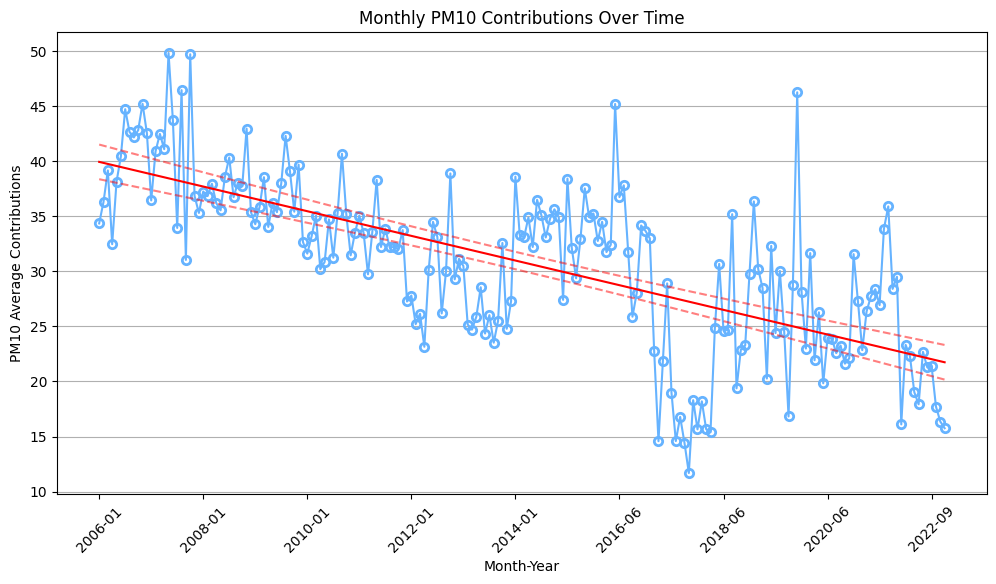

In [40]:
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def fetch_contributions(db_filename):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_filename)
    query = """
    SELECT D.date,
           SUM(C.contribution_value) AS total_pm10
    FROM Contributions C
    JOIN Dates D ON C.date_id = D.date_id
    GROUP BY D.date
    ORDER BY D.date;
    """
    # Read data from the database into a DataFrame
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def plot_monthly_pm10_trend(df):
    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Extract the year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Group by year and month and calculate the average PM10 contribution for each month
    monthly_avg = df.groupby(['year', 'month'])['total_pm10'].mean().reset_index()

    # Create a 'month_year' column for better x-axis labels
    monthly_avg['month_year'] = monthly_avg['year'].astype(str) + '-' + monthly_avg['month'].astype(str).str.zfill(2)

    # Create a time variable for statsmodels regression
    time = np.arange(len(monthly_avg))

    # Add a constant to the model (intercept)
    X = sm.add_constant(time)
    y = monthly_avg['total_pm10']

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Plot the monthly trend chart
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg['month_year'], monthly_avg['total_pm10'], marker='o', linestyle='-', color='#66b3ff', markerfacecolor='none', markeredgewidth=2)

    # Plot the trend line
    plt.plot(monthly_avg['month_year'], model.predict(X), linestyle='-', color='red')

    # Plot the 95% confidence intervals for the trend
    # Get the confidence intervals for the predicted values
    ci = model.get_prediction(X).conf_int()

    # Plot the lower and upper confidence intervals
    plt.plot(monthly_avg['month_year'], ci[:, 0], linestyle='--', color='red', alpha=0.5)
    plt.plot(monthly_avg['month_year'], ci[:, 1], linestyle='--', color='red', alpha=0.5)

    plt.title('Monthly PM10 Contributions Over Time')
    plt.xlabel('Month-Year')
    plt.ylabel('PM10 Average Contributions')

    # Fix the x-axis to display labels every 2 years
    plt.xticks(ticks=range(0, len(monthly_avg['month_year']), 24), labels=monthly_avg['month_year'][::24], rotation=45)

    # Remove vertical grid lines and keep horizontal ones
    plt.grid(axis='y')

    plt.show()

# Define the database filename
db_filename = 'trend_analysis_contributions.db'

# Fetch the contribution data from the database
contributions_df = fetch_contributions(db_filename)

# Plot the monthly PM10 trend
plot_monthly_pm10_trend(contributions_df)

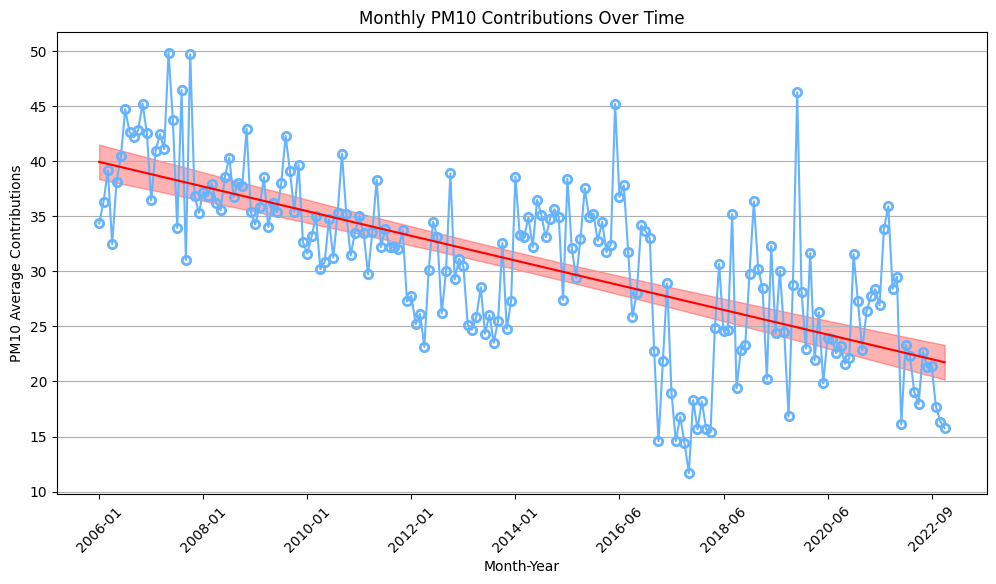

In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def plot_monthly_pm10_trend(df):
    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Extract the year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Group by year and month and calculate the average PM10 contribution for each month
    monthly_avg = df.groupby(['year', 'month'])['total_pm10'].mean().reset_index()

    # Create a 'month_year' column for better x-axis labels
    monthly_avg['month_year'] = monthly_avg['year'].astype(str) + '-' + monthly_avg['month'].astype(str).str.zfill(2)

    # Create a time variable for statsmodels regression
    time = np.arange(len(monthly_avg))

    # Add a constant to the model (intercept)
    X = sm.add_constant(time)
    y = monthly_avg['total_pm10']

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Plot the monthly trend chart
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg['month_year'], monthly_avg['total_pm10'], marker='o', linestyle='-', color='#66b3ff', markerfacecolor='none', markeredgewidth=2)

    # Plot the trend line
    plt.plot(monthly_avg['month_year'], model.predict(X), linestyle='-', color='red')

    # Get the confidence intervals for the predicted values
    ci = model.get_prediction(X).conf_int()

    # Plot the lower and upper confidence intervals (shifted by the same offset)
    plt.fill_between(monthly_avg['month_year'], ci[:, 0], ci[:, 1], color='red', alpha=0.3)

    plt.title('Monthly PM10 Contributions Over Time')
    plt.xlabel('Month-Year')
    plt.ylabel('PM10 Average Contributions')

    # Fix the x-axis to display labels every 2 years
    plt.xticks(ticks=range(0, len(monthly_avg['month_year']), 24), labels=monthly_avg['month_year'][::24], rotation=45)

    # Remove vertical grid lines and keep horizontal ones
    plt.grid(axis='y')

    plt.show()


# Define the database filename
db_filename = 'trend_analysis_contributions.db'

# Fetch the contribution data from the database
contributions_df = fetch_contributions(db_filename)

# Plot the monthly PM10 trend
plot_monthly_pm10_trend(contributions_df)

Data Extraction- QueenStreetPM10PMFDataUncert_May2023

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# Read the Excel file into a DataFrame
df = pd.read_excel("QueenStreetPM10PMFDataUncert_May2023.xlsx", sheet_name="PMFData")

# Calculate the sum of missing values for each column
missing_values = df.isnull().sum()
print("Missing values before dropping:")
print(missing_values)

# Drop rows with any missing values
df_cleaned = df.dropna()

# Calculate the sum of missing values again to confirm they are gone
missing_values_after = df_cleaned.isnull().sum()
print("\nMissing values after dropping:")
print(missing_values_after)

Missing values before dropping:
Date    1
PM10    0
H       1
BC      1
Na      1
Mg      1
Al      1
Si      1
P       1
S       1
Cl      1
K       1
Ca      1
Sc      1
Ti      1
V       1
Cr      1
Mn      1
Fe      1
Co      1
Ni      1
Cu      1
Zn      1
Ga      1
Ge      1
As      1
Se      1
Br      1
Rb      1
Sr      1
Mo      1
I       1
Ba      1
Hg      1
Pb      1
dtype: int64

Missing values after dropping:
Date    0
PM10    0
H       0
BC      0
Na      0
Mg      0
Al      0
Si      0
P       0
S       0
Cl      0
K       0
Ca      0
Sc      0
Ti      0
V       0
Cr      0
Mn      0
Fe      0
Co      0
Ni      0
Cu      0
Zn      0
Ga      0
Ge      0
As      0
Se      0
Br      0
Rb      0
Sr      0
Mo      0
I       0
Ba      0
Hg      0
Pb      0
dtype: int64


Create Database

In [48]:
import sqlite3
import os

def drop_database(db_filename):
    # If the database file exists, delete it
    if os.path.exists(db_filename):
        os.remove(db_filename)
        print(f"Database file {db_filename} has been deleted.")
    else:
        print(f"Database file {db_filename} does not exist.")

def create_database(db_filename):
    # Connect to a SQLite database, this will create a new empty database file
    conn = sqlite3.connect(db_filename)

    # SQL statement to create a table
    create_dates_table = """
    CREATE TABLE IF NOT EXISTS Dates (
        date_id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT NOT NULL
    );
    """
    create_factors_table = """
    CREATE TABLE IF NOT EXISTS Factors (
        factor_id INTEGER PRIMARY KEY AUTOINCREMENT,
        factor_name TEXT NOT NULL
    );
    """
    create_contributions_table = """
    CREATE TABLE IF NOT EXISTS Contributions (
        contribution_id INTEGER PRIMARY KEY AUTOINCREMENT,
        date_id INTEGER,
        factor_id INTEGER,
        contribution_value REAL,
        FOREIGN KEY (date_id) REFERENCES Dates(date_id),
        FOREIGN KEY (factor_id) REFERENCES Factors(factor_id)
    );
    """

    # Execute SQL statements to create tables
    cursor = conn.cursor()
    cursor.execute(create_dates_table)
    cursor.execute(create_factors_table)
    cursor.execute(create_contributions_table)

    # confirm operation
    conn.commit()

    # close connections
    conn.close()
    print(f"Database file {db_filename} has been created.")

# using function
db_filename = 'QueenStreetPM10PMFDataUncert_May2023.db'
drop_database(db_filename)  # Delete database
create_database(db_filename)  # Create database

Database file QueenStreetPM10PMFDataUncert_May2023.db does not exist.
Database file QueenStreetPM10PMFDataUncert_May2023.db has been created.


**Insert Dataset-QueenStreetPM10PMFDataUncert_May2023**

In [51]:
import sqlite3
import os
import pandas as pd

# Function to drop the database if it exists
def drop_database(db_filename):
    if os.path.exists(db_filename):
        os.remove(db_filename)
        print(f"Database file {db_filename} has been deleted.")
    else:
        print(f"Database file {db_filename} does not exist.")

# Function to create the database and tables
def create_database(db_filename):
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Dates (
        date_id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT NOT NULL
    );
    """)
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Factors (
        factor_id INTEGER PRIMARY KEY AUTOINCREMENT,
        factor_name TEXT NOT NULL UNIQUE
    );
    """)
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Contributions (
        contribution_id INTEGER PRIMARY KEY AUTOINCREMENT,
        date_id INTEGER,
        factor_id INTEGER,
        contribution_value REAL,
        FOREIGN KEY (date_id) REFERENCES Dates(date_id),
        FOREIGN KEY (factor_id) REFERENCES Factors(factor_id)
    );
    """)
    conn.commit()
    conn.close()
    print(f"Database file {db_filename} has been created.")

# Function to insert dates into the Dates table
def insert_dates_to_table(db_filename, df):
    if 'Date' not in df.columns:
        print("Error: 'Date' column not found in DataFrame.")
        return
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    insert_date = "INSERT INTO Dates (date) VALUES (?)"
    df['Date'] = df['Date'].astype(str)
    df = df.dropna(subset=['Date'])
    for index, row in df.iterrows():
        cursor.execute(insert_date, (row['Date'],))
    conn.commit()
    conn.close()
    print("Dates have been inserted into the Dates table.")

# Function to insert factors into the Factors table
def insert_factors_to_table(db_filename, df):
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    insert_factor = "INSERT INTO Factors (factor_name) VALUES (?)"
    for col in df.columns[df.columns != 'Date']:
        try:
            cursor.execute(insert_factor, (col,))
        except sqlite3.IntegrityError:
            print(f"Factor {col} already exists in the Factors table.")
    conn.commit()
    conn.close()
    print("Factors have been inserted into the Factors table.")

# Function to insert contributions into the Contributions table
def insert_contributions_to_table(db_filename, df):
    if 'Date' not in df.columns:
        print("Error: 'Date' column not found in DataFrame.")
        return
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    insert_contribution = "INSERT INTO Contributions (date_id, factor_id, contribution_value) VALUES (?, ?, ?)"
    for index, row in df.iterrows():
        date_id_query = "SELECT date_id FROM Dates WHERE date = ?"
        cursor.execute(date_id_query, (row['Date'],))
        date_id_result = cursor.fetchone()
        if date_id_result:
            date_id = date_id_result[0]
        else:
            print(f"Date {row['Date']} not found in Dates table.")
            continue
        for col in df.columns[df.columns != 'Date']:
            factor_id_query = "SELECT factor_id FROM Factors WHERE factor_name = ?"
            cursor.execute(factor_id_query, (col,))
            factor_id_result = cursor.fetchone()
            if factor_id_result:
                factor_id = factor_id_result[0]
            else:
                print(f"Factor {col} not found in Factors table.")
                continue
            contribution_value = row[col]
            cursor.execute(insert_contribution, (date_id, factor_id, contribution_value))
    conn.commit()
    conn.close()
    print("Contributions have been inserted into the Contributions table.")

# Database filename
db_filename = 'QueenStreetPM10PMFDataUncert_May2023.db'

# Drop existing database
drop_database(db_filename)

# Create new database
create_database(db_filename)

# Read DataFrame from Excel file
df = pd.read_excel("QueenStreetPM10PMFDataUncert_May2023.xlsx", sheet_name="PMFData")

# Insert dates into the database
insert_dates_to_table(db_filename, df)

# Insert factors into the database
insert_factors_to_table(db_filename, df)

# Insert contributions into the database
insert_contributions_to_table(db_filename, df)

Database file QueenStreetPM10PMFDataUncert_May2023.db has been deleted.
Database file QueenStreetPM10PMFDataUncert_May2023.db has been created.
Dates have been inserted into the Dates table.
Factors have been inserted into the Factors table.
Contributions have been inserted into the Contributions table.


Test

In [53]:
import sqlite3

# Database filename
db_filename = 'QueenStreetPM10PMFDataUncert_May2023.db'

# Function to test the database
def test_database(db_filename):
    # Connect to the database
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Test if the Dates table is not empty
    cursor.execute("SELECT * FROM Dates")
    dates = cursor.fetchall()
    print("Dates table is not empty:", len(dates) > 0)

    # Test if the Factors table is not empty
    cursor.execute("SELECT * FROM Factors")
    factors = cursor.fetchall()
    print("Factors table is not empty:", len(factors) > 0)

    # Test if the Contributions table is not empty
    cursor.execute("SELECT * FROM Contributions")
    contributions = cursor.fetchall()
    print("Contributions table is not empty:", len(contributions) > 0)

    # Test if we can retrieve a specific date
    test_date = dates[0][1] if dates else None
    if test_date:
        cursor.execute("SELECT * FROM Dates WHERE date = ?", (test_date,))
        date_result = cursor.fetchone()
        print(f"Date {test_date} found in Dates table:", date_result is not None)

    # Test if we can retrieve a specific factor
    test_factor = factors[0][1] if factors else None
    if test_factor:
        cursor.execute("SELECT * FROM Factors WHERE factor_name = ?", (test_factor,))
        factor_result = cursor.fetchone()
        print(f"Factor {test_factor} found in Factors table:", factor_result is not None)

    # Test if we can retrieve contributions for a specific date and factor
    if test_date and test_factor:
        cursor.execute("SELECT * FROM Contributions WHERE date_id = (SELECT date_id FROM Dates WHERE date = ?) AND factor_id = (SELECT factor_id FROM Factors WHERE factor_name = ?)", (test_date, test_factor))
        contribution_result = cursor.fetchone()
        print(f"Contributions found for date {test_date} and factor {test_factor}:", contribution_result is not None)

    # Close the connection
    conn.close()

# Run the test function
test_database(db_filename)

Dates table is not empty: True
Factors table is not empty: True
Contributions table is not empty: True
Date 2006-01-06 found in Dates table: True
Factor PM10 found in Factors table: True
Contributions found for date 2006-01-06 and factor PM10: True


Visulaizaton- QueenStreetPM10PMFDataUncert_May2023.db_ *PM10*

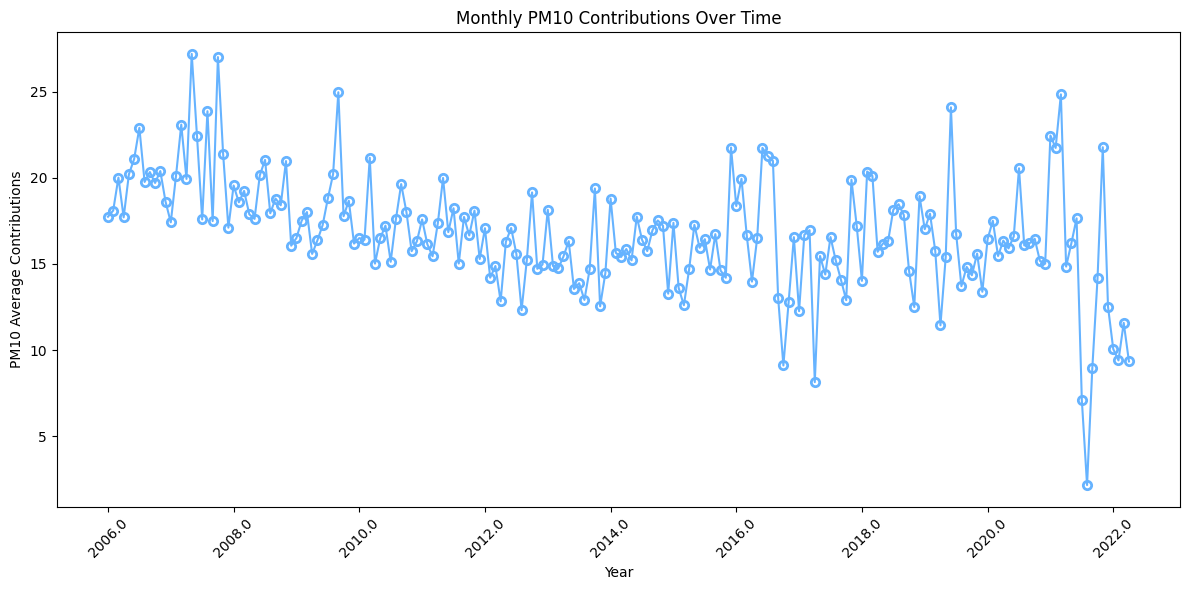

In [63]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

# Database filename
db_filename = 'QueenStreetPM10PMFDataUncert_May2023.db'

# Function to retrieve PM10 data over time
def get_pm10_data(db_filename):
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Query to retrieve PM10 data along with corresponding dates
    query = """
    SELECT D.date, C.contribution_value
    FROM Contributions C
    JOIN Factors F ON C.factor_id = F.factor_id
    JOIN Dates D ON C.date_id = D.date_id
    WHERE F.factor_name = 'PM10'
    ORDER BY D.date ASC;
    """
    cursor.execute(query)
    pm10_data = cursor.fetchall()

    # Convert the data to a pandas DataFrame
    dates = [item[0] for item in pm10_data]
    pm10_values = [item[1] for item in pm10_data]

    df_pm10 = pd.DataFrame({
        'date': dates,
        'total_pm10': pm10_values
    })

    # Close the connection
    conn.close()

    return df_pm10

# Function to plot the trend of PM10 over time
def plot_pm10_trend(df_pm10):
    # Ensure the 'date' column is in datetime format
    df_pm10['date'] = pd.to_datetime(df_pm10['date'])

    # Extract the year and month
    df_pm10['year'] = df_pm10['date'].dt.year
    df_pm10['month'] = df_pm10['date'].dt.month

    # Group by year and month and calculate the average PM10 contribution for each month
    monthly_avg = df_pm10.groupby(['year', 'month'])['total_pm10'].mean().reset_index()

    # Create a 'month_year' column for better x-axis labels
    monthly_avg['month_year'] = monthly_avg['year'].astype(str) + '-' + monthly_avg['month'].astype(str).str.zfill(0)

    # Plot the monthly trend chart
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg['month_year'], monthly_avg['total_pm10'], marker='o', linestyle='-', color='#66b3ff', markerfacecolor='none', markeredgewidth=2)
    plt.title('Monthly PM10 Contributions Over Time')
    plt.xlabel('Year')
    plt.ylabel('PM10 Average Contributions')

    # Fix the x-axis to display labels every 2 years
    plt.xticks(ticks=range(0, len(monthly_avg['year']), 24), labels=monthly_avg['year'][::24], rotation=45)

    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Retrieve PM10 data
df_pm10 = get_pm10_data(db_filename)

# Plot the trend
plot_pm10_trend(df_pm10)

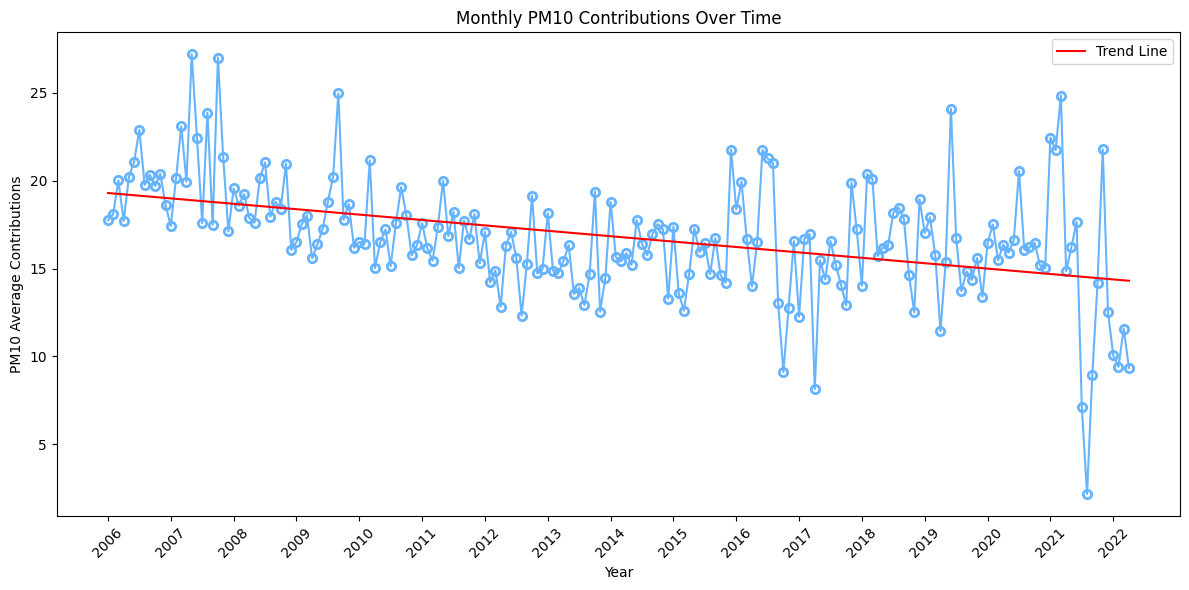

In [78]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

# Database filename
db_filename = 'QueenStreetPM10PMFDataUncert_May2023.db'

# Function to retrieve PM10 data over time
def get_pm10_data(db_filename):
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Query to retrieve PM10 data along with corresponding dates
    query = """
    SELECT D.date, C.contribution_value
    FROM Contributions C
    JOIN Factors F ON C.factor_id = F.factor_id
    JOIN Dates D ON C.date_id = D.date_id
    WHERE F.factor_name = 'PM10'
    ORDER BY D.date ASC;
    """
    cursor.execute(query)
    pm10_data = cursor.fetchall()

    # Convert the data to a pandas DataFrame
    dates = [item[0] for item in pm10_data]
    pm10_values = [item[1] for item in pm10_data]

    df_pm10 = pd.DataFrame({
        'date': dates,
        'total_pm10': pm10_values
    })

    # Close the connection
    conn.close()

    return df_pm10

# Function to plot the trend of PM10 over time
def plot_pm10_trend(df_pm10):
    # Ensure the 'date' column is in datetime format
    df_pm10['date'] = pd.to_datetime(df_pm10['date'])

    # Extract the year and month
    df_pm10['year'] = df_pm10['date'].dt.year
    df_pm10['month'] = df_pm10['date'].dt.month

    # Group by year and month and calculate the average PM10 contribution for each month
    monthly_avg = df_pm10.groupby(['year', 'month'])['total_pm10'].mean().reset_index()

    # Create a 'month_year' column for better x-axis labels
    monthly_avg['month_year'] = monthly_avg['year'].astype(str) + '-' + monthly_avg['month'].astype(str).str.zfill(2)

    # Perform linear regression to get the trend line
    X = np.arange(len(monthly_avg))
    Y = monthly_avg['total_pm10']
    slope, intercept, r_value, p_value, std_err = linregress(X, Y)

    # Plot the monthly trend chart
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg['month_year'], monthly_avg['total_pm10'], marker='o', linestyle='-', color='#66b3ff', markerfacecolor='none', markeredgewidth=2)

    # Add the red solid trend line
    plt.plot(monthly_avg['month_year'], slope * X + intercept, color='red', linestyle='-', label='Trend Line')

    plt.title('Monthly PM10 Contributions Over Time')
    plt.xlabel('Year')
    plt.ylabel('PM10 Average Contributions')

    # Fix the x-axis to display labels every 2 years
    plt.xticks(ticks=range(0, len(monthly_avg), 12), labels=[str(int(year)) for year in monthly_avg['year'][::12]], rotation=45)

    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Retrieve PM10 data
df_pm10 = get_pm10_data(db_filename)

# Plot the trend
plot_pm10_trend(df_pm10)

Visulaizaton- QueenStreetPM10PMFDataUncert_May2023.db_ all factors

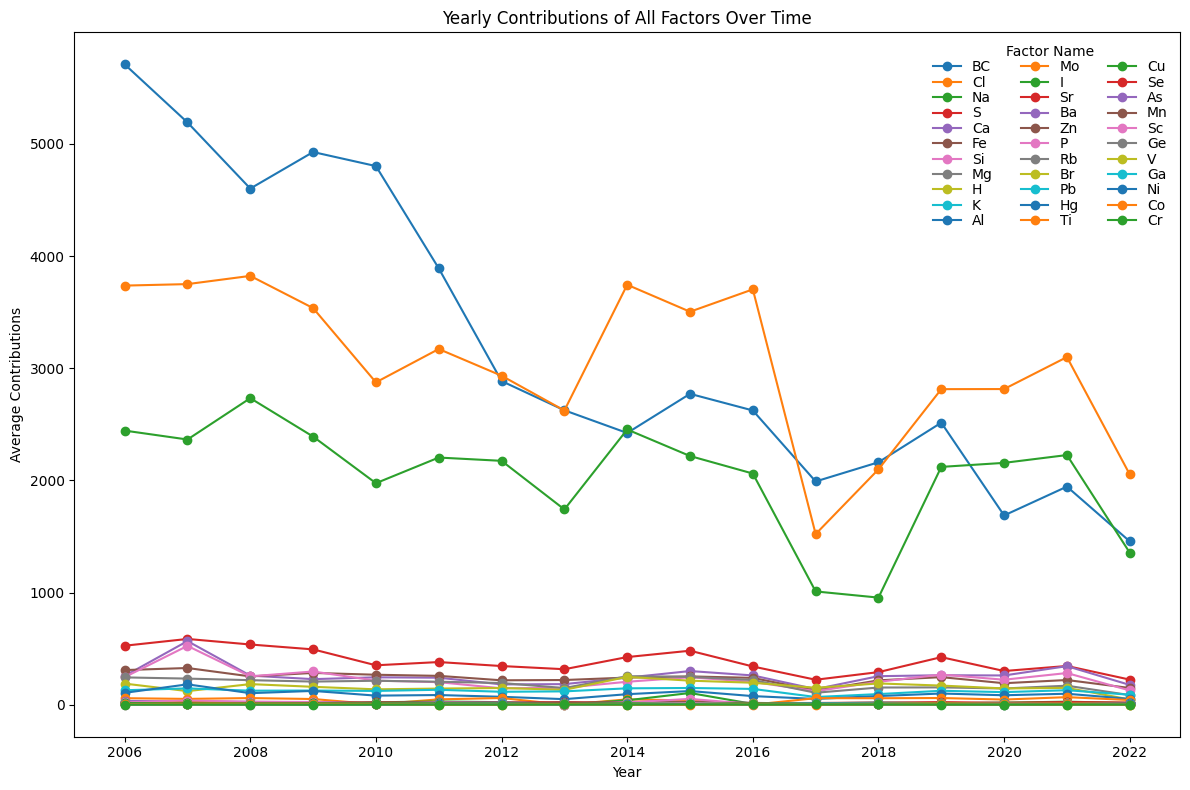

In [103]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

# Database filename
db_filename = 'QueenStreetPM10PMFDataUncert_May2023.db'

# Function to retrieve data for all factors except PM10
def get_all_factors_data(db_filename):
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Query to retrieve data for all factors except PM10 along with corresponding dates
    query = """
    SELECT F.factor_name, D.date, C.contribution_value
    FROM Contributions C
    JOIN Factors F ON C.factor_id = F.factor_id
    JOIN Dates D ON C.date_id = D.date_id
    WHERE F.factor_name <> 'PM10'
    ORDER BY D.date ASC, F.factor_name ASC;
    """
    cursor.execute(query)
    all_factors_data = cursor.fetchall()

    # Close the connection
    conn.close()

    return all_factors_data

# Function to process and plot the trend of all factors
def plot_all_factors_trend(all_factors_data):
    # Convert the data to a pandas DataFrame
    factors_data = pd.DataFrame(all_factors_data, columns=['factor_name', 'date', 'contribution_value'])

    # Ensure the 'date' column is in datetime format
    factors_data['date'] = pd.to_datetime(factors_data['date'])

    # Extract the year
    factors_data['year'] = factors_data['date'].dt.year

    # Group by year, factor_name and calculate the average contribution for each year and factor
    yearly_avg = factors_data.groupby(['year', 'factor_name'])['contribution_value'].mean().reset_index()

    # Calculate the total average contribution for each factor to sort the legend
    total_avg = yearly_avg.groupby('factor_name')['contribution_value'].mean().sort_values(ascending=False)

    # Plot the yearly trend chart for all factors
    plt.figure(figsize=(12, 8))  # Adjusted figure size for better proportions
    for factor in total_avg.index:
        factor_data = yearly_avg[yearly_avg['factor_name'] == factor]
        plt.plot(factor_data['year'], factor_data['contribution_value'], marker='o', linestyle='-', label=factor)

    plt.title('Yearly Contributions of All Factors Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Contributions')

    # Create a legend and place it at the top right corner inside the plot
    plt.legend(title='Factor Name', loc='upper right', ncol=3, labelspacing=0.1, frameon=False)

    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Retrieve data for all factors except PM10
all_factors_data = get_all_factors_data(db_filename)

# Plot the trend for all factors
plot_all_factors_trend(all_factors_data)